In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import re

## Unsupervised Learning Capstone

The goal for this project is to exercise and apply unsupervised learning techniques. To do this we are going to use spacys' unsupervised neural networks and word vector library to generate document vectors for each song in our data set. Then we are going to use supervised classifiers on our vectors to classify which genre a lyric comes from. Also we will use various clustering methods from sci kit learn to see if we can find any hiden data structure in our document vectors. We will also look at genre counts for each cluster to see if our clustering algorithims are picking up on the song genre, if they are not picking up on the genre labels then we will test the clusters across samples to see if they are consistant in the unlabeled data structures they find.

In [2]:
df = pd.read_csv('lyrics.csv')
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [3]:
df.shape

(362237, 6)

In [4]:
df.isnull().sum()

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64

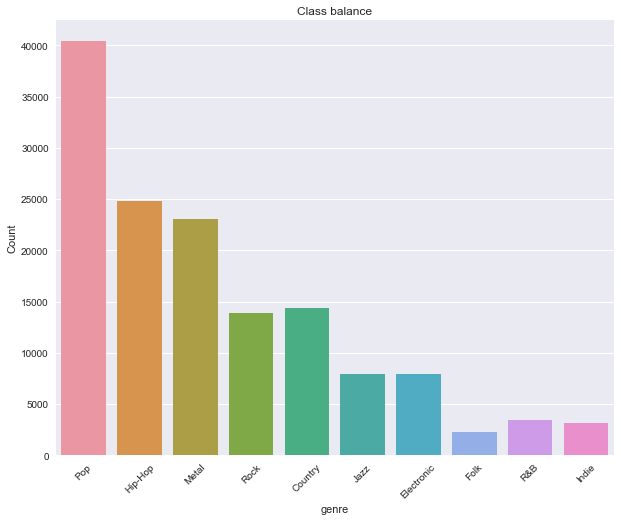

total observations: 141192


In [5]:
#Cleaning text, This should catch a lot of things spacys neural networks don't.
def text_cleaner(text):
    text = re.sub(r'--',' ',text)
    # Get rid of headings in square brackets.
    text = re.sub("[\[].*?[\]]", "", text)
    # Get rid of \n.
    text = re.sub(r"\n", " ", text)
    # Get rid of extra whitespace.
    text = ' '.join(text.split())
    return text

df.dropna(inplace=True)
df.lyrics = df.lyrics.apply(text_cleaner)

#Droping all rows with null values, the 10,000 rows with out lyrics can't be used
#and the two rows with out song ids won't be missed
#Also droping rows where lyrics were missing, but not NAN, and Rows where genre is not available/other
df.dropna(inplace=True)
df.drop((df[df.genre == 'Not Available'].index),inplace=True, axis=0)
df.drop((df[df.genre == 'Other'].index),inplace=True, axis=0)
df.drop((df[df.lyrics.str.len() < 1].index), inplace=True, axis=0)

#Class balance is way off undersampling rock which represents about a third of our data set
rock_index = df[df.genre == 'Rock'].index
#select rows to drop
random_indices = np.random.choice(rock_index, 95000, replace=False)
#drop selected rows
df.drop(random_indices, inplace=True, axis=0)

plt.figure(figsize=(10,8))
plt.title('Class balance')
sns.countplot(x="genre", data=df)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print('total observations:', df.shape[0])

#for now reducing data set to 10,000 to save time
#df = df.sample(15000, random_state=42)
#df.reset_index(inplace=True, drop=True)
#df.drop('index', inplace=True, axis=1)
#df.shape

In [6]:
#Language detection was out of the scope of this project so we're just doing a quick and dirty clean up
#with pythons' langdetect package. Droping all rows where language was not english.
from langdetect import detect

def detect_try(text):
    try:
        return detect(text)
    except:
        return 'error'

#Language column
df['language'] = df.lyrics.apply(detect_try)
print(df.language.value_counts())

#droping language column and rows that aren't english
df.drop((df[df.language != 'en'].index), inplace=True, axis=0)
df.drop('language', inplace=True, axis=1)

df.shape

en       128829
es         3968
de         1772
fr         1146
id          984
it          804
ro          752
pt          456
sw          262
no          251
tr          250
nl          249
fi          203
sv          195
tl          162
error       111
so          105
hr          101
hu           97
sq           84
cy           70
da           63
ca           62
af           58
pl           53
et           32
sl           24
lt           23
vi           12
sk            6
cs            4
ja            2
lv            2
Name: language, dtype: int64


(128829, 6)

In [7]:
pd.set_option('display.max_colwidth', 500)
df.lyrics.head(2)

0    Oh baby, how you doing? You know I'm gonna cut right to the chase Some women were made but me, myself I like to think that I was created for a special purpose You know, what's more special than you? You feel me It's on baby, let's get lost You don't need to call into work 'cause you're the boss For real, want you to show me how you feel I consider myself lucky, that's a big deal Why? Well, you got the key to my heart But you ain't gonna need it, I'd rather you open up my body And show me sec...
1    playin' everything so easy, it's like you seem so sure. still your ways, you dont see i'm not sure if they're for me. then things come right along our way, though we didn't truly ask. it seems as if they're gonna linger with every delight they bring, just like what you have truly seemed. i'm trying to think of what you really want to say, even through my darkest day. you might want to leave me, feeling strange about you like you're gonna let me know, when words then slipped out of you.

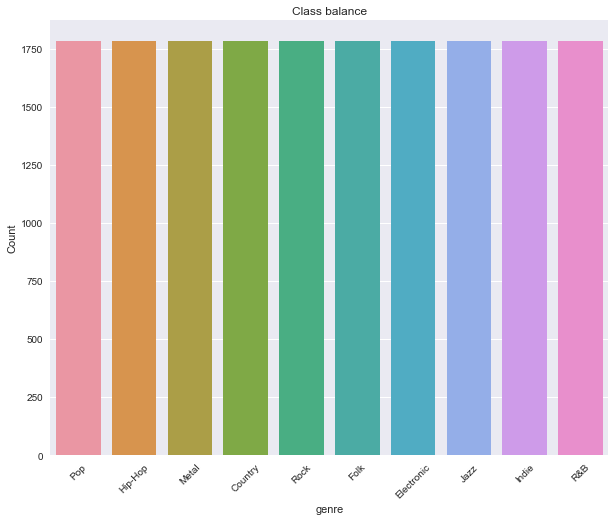

total observations: 17820


In [28]:
#Fixing class balance
indices_to_drop = []
for X in df.genre.unique():
    #get all indices for X genre
    indices_x = df[df.genre == X].index
    #how many to drop
    num = (df.genre[df.genre == X].count()) - (df.genre.value_counts().min())
    #sel
    random_indices = list(np.random.choice(indices_x, num, replace=False))
    indices_to_drop += random_indices
    
df.drop(indices_to_drop, inplace=True, axis=0)
    
plt.figure(figsize=(10,8))
plt.title('Class balance')
sns.countplot(x="genre", data=df)
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print('total observations:', df.shape[0])

In [29]:
#removing chained assignment warning
pd.options.mode.chained_assignment = None

#Loading the spacy english model
#Using Spacy to parse lyrics and create docs
#This spacy model has 1.1 million word vectors that will help us generate our doc vectors.
nlp = spacy.load('en_vectors_web_lg')
vectors = [] 

#Get vectors
for doc in nlp.pipe(iter(df['lyrics']),batch_size=256):
    vectors.append(doc.vector)

#Create vector DF and concat to our original DF
vector_df = pd.DataFrame(vectors)
vector_df.reset_index(drop=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df = pd.concat([df, vector_df], axis=1)

In [31]:
def score_support(clf, X_train, y_train, X_test, y_test):
    print('train score:', clf.score(X_train, y_train))
    print('test score:', clf.score(X_test, y_test))

X = df.loc[:,~df.columns.isin(['song', 'year', 'artist', 'genre', 'lyrics'])]
y = df.loc[:,'genre']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [32]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=1, random_state=42)
svc.fit(X_train, y_train)

score_support(svc, X_train, y_train, X_test, y_test)

train score: 0.0981341189674523
test score: 0.09652076318742986


In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(max_depth=6, n_estimators=200, learning_rate=.1)
gbc.fit(X_train, y_train)

score_support(gbc, X_train, y_train, X_test, y_test)

train score: 1.0
test score: 0.5642536475869809


In [34]:
from sklearn.neighbors import KNeighborsClassifier

knn= KNeighborsClassifier(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)

score_support(knn, X_train, y_train, X_test, y_test)

train score: 1.0
test score: 0.8538159371492705


In [35]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=5)
lr.fit(X_train, y_train)

score_support(lr, X_train, y_train, X_test, y_test)

train score: 0.09995791245791245
test score: 0.10016835016835017


In [37]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(155,), max_iter=400)
mlp.fit(X_train, y_train)

score_support(mlp, X_train, y_train, X_test, y_test)

train score: 0.1002384960718294
test score: 0.09932659932659933
